In [1]:
%load_ext autoreload
%autoreload 2

### Basic Imports

In [2]:
import nbimporter
from typing import Dict, Tuple, List
import numpy as np
from tqdm import tqdm

### Env Vars

In [3]:
QUBITS_NUM = 4 
N = 2**QUBITS_NUM
K = 4

w = 0.5

NUM_SHOTS = 1024
NUM_ITERATIONS = 100

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

### Simulator Backend

In [4]:
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals

seed = 50
algorithm_globals.random_seed = seed

simulator_backend = Aer.get_backend('qasm_simulator')

### Optimizer

In [5]:
from scipy.optimize import minimize

### K input states (computational basis)

In [6]:
from utiles import *

In [7]:
input_states = get_first_k_eigenvectors_from_n_computational_basis(K, N)

### Ansatz State

In [8]:
from ansatz_circuit_item2 import get_full_variational_quantum_circuit

In [9]:
init_circuit_params = {
    "thetas": np.random.uniform(low=0, high=2*np.pi, size=8),
    "phis": np.random.uniform(low=0, high=2*np.pi, size=4),
    "D1": 2,
    "D2": 6
}

In [10]:
def prepare_circuit_params(thetas) -> Dict:
     return {
    "thetas": thetas[4:],
    "phis": thetas[:4],
    "D1": 2,
    "D2": 6
     }

In [11]:
def get_ansatz_state(circuit_params, input_state):
    circuit_params_with_input_state = {**circuit_params, "input_state": input_state}
    return get_full_variational_quantum_circuit(**circuit_params_with_input_state)

## Expectation Value

### convert hamiltonian to pauli strings

In [12]:
def transfrom_hamiltonian_into_pauli_strings(hamiltonian) -> List:
    pauli_operators = hamiltonian.to_pauli_op().settings['oplist']
    pauli_coeffs = list(map(lambda pauli_operator: pauli_operator.coeff, pauli_operators))
    pauli_strings = list(map(lambda pauli_operator: pauli_operator.primitive, pauli_operators))
    return pauli_coeffs, pauli_strings

### pauli string reduction to sigma_z's

In [13]:
from qiskit.circuit.library.standard_gates import HGate, SGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

In [14]:
reducing_to_pauli_z_mapping = {
    'I': 'I',
    'Z': 'Z',
    'X': 'Z',
    'Y': 'Z'
} 

In [15]:
def reduce_pauli_matrixes_into_sigma_z(pauli_string) -> str:
    reduced_pauli_string = ""
    for matrix_index in range(QUBITS_NUM):
        pauli_matrix = str(pauli_string[matrix_index])
        reduced_pauli_matrix = reducing_to_pauli_z_mapping[pauli_matrix]
        reduced_pauli_string = reduced_pauli_matrix + reduced_pauli_string
    
    return reduced_pauli_string

In [16]:
def add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string, quantum_circuit):
    quantum_registers = QuantumRegister(QUBITS_NUM, name="qubit")
    additional_circuit_layer = QuantumCircuit(quantum_registers)
    
    for quantum_register_index, pauli_matrix in enumerate(pauli_string):
        if pauli_matrix == "X":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
        if pauli_string == "Y":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
            additional_circuit_layer.append(SGate(), [quantum_registers[quantum_register_index]])
                
    extended_quantum_circuit = quantum_circuit.compose(additional_circuit_layer)
    return extended_quantum_circuit

### probabilities distribution

In [17]:
def get_probability_distribution(counts: Dict) -> Dict:
    proba_distribution = {state: (count / NUM_SHOTS) for state, count in counts.items()}
    return proba_distribution

def calculate_probabilities_of_measurments_in_computational_basis(quantum_state_circuit) -> Dict:
    quantum_state_circuit.measure_all()
    
    transpiled_quantum_state_circuit = transpile(quantum_state_circuit, simulator_backend) 
    Qobj = assemble(transpiled_quantum_state_circuit)
    result = simulator_backend.run(Qobj).result()
    counts = result.get_counts(quantum_state_circuit)
    
    return get_probability_distribution(counts)

### Expectation value from probabilities

In [18]:
def sort_probas_dict_by_qubits_string_keys(proba_distribution: Dict) -> Dict:
    return dict(sorted(proba_distribution.items()))

def reset_power_of_minus_1(power_of_minus_1):
    power_of_minus_1 = 0
    return power_of_minus_1

def convert_pauli_string_into_str(pauli_string) -> str:
    return str(pauli_string)

def calculate_expectation_value_of_pauli_string_by_measurments_probas(pauli_string, ansatz_circuit):
    pauli_string_expectation_value = 0
    power_of_minus_1 = 0
    
    pauli_string_str = convert_pauli_string_into_str(pauli_string)
    extended_ansatz_circuit = add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string_str, ansatz_circuit)
    probas_distribution = calculate_probabilities_of_measurments_in_computational_basis(extended_ansatz_circuit)
    
    reduced_pauli_string = reduce_pauli_matrixes_into_sigma_z(pauli_string)
    sorted_probas_distribuition = sort_probas_dict_by_qubits_string_keys(probas_distribution)
    for qubits_string, proba in sorted_probas_distribuition.items():
        for string_index in range(QUBITS_NUM):
            if(str(qubits_string[string_index])=="1" and str(reduced_pauli_string[string_index])=="Z"):
                power_of_minus_1 += 1
            
        pauli_string_expectation_value += pow(-1, power_of_minus_1)*proba
        power_of_minus_1 = reset_power_of_minus_1(power_of_minus_1)
        
    return pauli_string_expectation_value

In [19]:
def get_expectation_value(ansatz_circuit, pauli_coeffs, pauli_strings):
    total_expection_value = 0
    
    for pauli_coeff, pauli_string in tqdm(zip(pauli_coeffs, pauli_strings)):
        total_expection_value += pauli_coeff*calculate_expectation_value_of_pauli_string_by_measurments_probas(
                                                                                    pauli_string, ansatz_circuit)
    
    return total_expection_value

## Objective Function

In [20]:
from qiskit import assemble, transpile

def cost_function(thetas, hamiltonian):
    circuit_params = prepare_circuit_params(thetas)
    computational_eigenvectors = get_first_k_eigenvectors_from_n_computational_basis(K, N)
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    k_ansatz_state = get_ansatz_state(circuit_params, computational_eigenvectors[K-1])
    
    approximated_energey = get_expectation_value(k_ansatz_state, pauli_coeffs, pauli_strings)
    insert_approximated_energy_to_list_of_all_approximated_energies(approximated_energey)
    
    L_w = w*approximated_energey
    for j in range(K-1):
        ansatz_state = get_ansatz_state(circuit_params, computational_eigenvectors[j])
        L_w += get_expectation_value(ansatz_state, pauli_coeffs, pauli_strings)
        
    return L_w

## Optimization

In [21]:
def get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian):
    initial_thetas = np.random.uniform(low=0, high=2*np.pi, size=PARAMS_NUM)
    optimizer_result = minimize(cost_function,
                                x0=initial_thetas,
                                args=(hamiltonian),
                                method="COBYLA",
                                options={"maxiter":NUM_ITERATIONS,
                                        "disp": True})
    optimal_thetas = optimizer_result.x
    
    return optimal_thetas

In [22]:
def get_approximated_eigenvalue_of_hamiltonian(hamiltonian):
    optimal_thetas = get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian)
    print("### The optimal parameters found by the optimizer ###")
    print(optimal_thetas)
    
    optimal_circuit_params = prepare_circuit_params(optimal_thetas)
    computational_eigenvectors = get_first_k_eigenvectors_from_n_computational_basis(K, N)
    optimal_ansatz_state = get_ansatz_state(optimal_circuit_params, computational_eigenvectors[K-1])
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    approximated_eigenvalue = get_expectation_value(optimal_ansatz_state, pauli_coeffs, pauli_strings)

    return approximated_eigenvalue

## Comparsion

In [23]:
from numpy import linalg as LA

def get_approximation_error(exact_eigenvalue, approximated_eigenvalue):
    return abs(abs(exact_eigenvalue)-abs(approximated_eigenvalue))/abs(exact_eigenvalue)

In [24]:
def get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian):
    eigen_values = LA.eigvals(hamiltonian.to_matrix())
    print(sorted(eigen_values))
    
    return min(sorted(eigen_values))

In [25]:
def compare_exact_and_approximated_eigenvalue(hamiltonian, approximated_eigenvalue):
    exact_eigenvalue = get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian)
    print("Exact Eigenvalue:")
    print(exact_eigenvalue)
    print("\nApproximated Eigenvalue:")
    print(approximated_eigenvalue)

    print("\nApproximation Error")
    print(get_approximation_error(exact_eigenvalue, approximated_eigenvalue))
    
    plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue, margin=3)
    initialize_approximated_energy_to_list_of_all_approximated_energies()

## Visualization

In [26]:
approximated_energies = []

In [27]:
def insert_approximated_energy_to_list_of_all_approximated_energies(energy):
    approximated_energies.append(energy)

In [28]:
def initialize_approximated_energy_to_list_of_all_approximated_energies():
    approximated_energies = []

In [29]:
import matplotlib.pyplot as plt

def plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue, margin):
    plt.title("convergence of optimization process to the exact eigenvalue")
    plt.margins(0, margin)
    plt.plot(approximated_energies)
    plt.axhline(y = exact_eigenvalue, color = 'r', linestyle = '-')
    plt.grid()
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")
    
def plot_fidelity():
    plt.plot(LiH_approximated_energies)
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")

## LiH Molecule 4 qubits

In [30]:
from qiskit.opflow import X, Z, I, H, Y

LiH_molecule_4_qubits = -7.49894690201071*(I^I^I^I) + \
                            -0.0029329964409502266*(X^X^Y^Y) + \
                            0.0029329964409502266*(X^Y^Y^X) + \
                            0.01291078027311749*(X^Z^X^I) + \
                            -0.0013743761078958677*(X^Z^X^Z) + \
                            0.011536413200774975*(X^I^X^I) + \
                            0.0029329964409502266*(Y^X^X^Y) + \
                            -0.0029329964409502266*(Y^Y^X^X) + \
                            0.01291078027311749*(Y^Z^Y^I) + \
                            -0.0013743761078958677*(Y^Z^Y^Z) + \
                            0.011536413200774975*(Y^I^Y^I) + \
                            0.16199475388004184*(Z^I^I^I) + \
                            0.011536413200774975*(Z^X^Z^X) + \
                            0.011536413200774975*(Z^Y^Z^Y) + \
                            0.12444770133137588*(Z^Z^I^I) + \
                            0.054130445793298836*(Z^I^Z^I) + \
                            0.05706344223424907*(Z^I^I^Z) + \
                            0.012910780273117487*(I^X^Z^X) + \
                            -0.0013743761078958677*(I^X^I^X) + \
                            0.012910780273117487*(I^Y^Z^Y) + \
                            -0.0013743761078958677*(I^Y^I^Y) + \
                            0.16199475388004186*(I^Z^I^I) + \
                            0.05706344223424907*(I^Z^Z^I) + \
                            0.054130445793298836*(I^Z^I^Z) + \
                            -0.013243698330265966*(I^I^Z^I) + \
                            0.08479609543670981*(I^I^Z^Z) + \
                            -0.013243698330265952*(I^I^I^Z)

In [31]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits)

27it [00:07,  3.52it/s]
27it [00:06,  4.39it/s]
27it [00:06,  4.30it/s]
27it [00:05,  4.55it/s]
27it [00:06,  3.92it/s]
27it [00:07,  3.51it/s]
27it [00:06,  4.04it/s]
27it [00:07,  3.66it/s]
27it [00:06,  4.18it/s]
27it [00:07,  3.40it/s]
27it [00:06,  4.15it/s]
27it [00:06,  3.93it/s]
27it [00:06,  4.16it/s]
27it [00:06,  4.41it/s]
27it [00:06,  4.10it/s]
27it [00:07,  3.68it/s]
27it [00:06,  3.92it/s]
27it [00:06,  4.36it/s]
27it [00:06,  4.10it/s]
27it [00:06,  4.08it/s]
27it [00:06,  4.44it/s]
27it [00:06,  4.45it/s]
27it [00:06,  4.33it/s]
27it [00:06,  4.45it/s]
27it [00:06,  4.26it/s]
27it [00:06,  4.22it/s]
27it [00:06,  4.32it/s]
27it [00:06,  4.15it/s]
27it [00:06,  4.39it/s]
27it [00:06,  4.25it/s]
27it [00:06,  4.22it/s]
27it [00:06,  3.91it/s]
27it [00:07,  3.78it/s]
27it [00:06,  4.01it/s]
27it [00:06,  4.43it/s]
27it [00:07,  3.80it/s]
27it [00:06,  4.17it/s]
27it [00:07,  3.84it/s]
27it [00:06,  4.07it/s]
27it [00:06,  3.94it/s]
27it [00:06,  4.02it/s]
27it [00:07,  3.

27it [00:09,  2.86it/s]
27it [00:08,  3.03it/s]
27it [00:10,  2.53it/s]
27it [00:09,  2.74it/s]
27it [00:10,  2.59it/s]
27it [00:09,  2.80it/s]
27it [00:09,  2.70it/s]
27it [00:09,  2.75it/s]
27it [00:10,  2.60it/s]
27it [00:10,  2.55it/s]
27it [00:11,  2.44it/s]
27it [00:10,  2.52it/s]
27it [00:10,  2.59it/s]
27it [00:09,  2.81it/s]
27it [00:09,  2.82it/s]
27it [00:10,  2.62it/s]
27it [00:09,  2.78it/s]
27it [00:10,  2.67it/s]
27it [00:09,  2.73it/s]
27it [00:10,  2.55it/s]
27it [00:09,  2.94it/s]
27it [00:08,  3.05it/s]
27it [00:08,  3.09it/s]
27it [00:08,  3.17it/s]
27it [00:10,  2.52it/s]
27it [00:10,  2.56it/s]
27it [00:10,  2.49it/s]
27it [00:10,  2.50it/s]
27it [00:11,  2.25it/s]
27it [00:11,  2.41it/s]
27it [00:12,  2.25it/s]
27it [00:12,  2.15it/s]
27it [00:12,  2.15it/s]
27it [00:11,  2.42it/s]
27it [00:12,  2.23it/s]
27it [00:11,  2.43it/s]
27it [00:10,  2.57it/s]
27it [00:11,  2.28it/s]
27it [00:13,  2.04it/s]
27it [00:11,  2.26it/s]
27it [00:10,  2.57it/s]
27it [00:09,  2.

### The optimal parameters found by the optimizer ###
[3.77686863 2.8245624  3.94368152 7.23595942 6.31729444 1.91264558
 1.878941   5.41801917 3.36974321 5.60650872 0.28914005 6.39030731
 2.01003391 6.2621716  2.65407197 1.75305986 0.88997872 2.44475298
 0.71833022 5.68107442 4.39504157 2.2594146  0.89748821 3.29908386
 1.50358705 5.77862179 2.07412707 4.93485258 3.86908826 1.6189979
 3.78328708 0.91569892]


27it [00:10,  2.50it/s]

CPU times: total: 39min 52s
Wall time: 54min 33s


### Comparsion between approximate value after optimtimzation and exact eigenvalue

[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.700475837803976+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.511999706834453+0j), (-7.511999706834451+0j), (-7.364817440287081+0j), (-7.151525481896562+0j), (-7.130406955301309+0j), (-7.130406955301308+0j), (-6.769813218087976+0j)]
Exact Eigenvalue:
(-7.862773163027979+0j)

Approximated Eigenvalue:
-7.5006941238282225

Approximation Error
0.04604978824803322


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


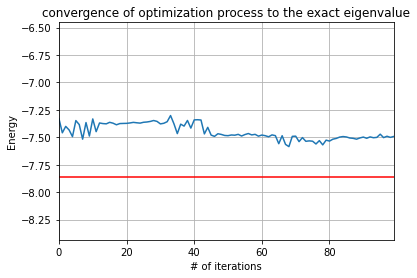

In [32]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

## H2 Molecule 4 qubits

In [33]:
H2_molecule_Hamiltonian_4_qubits =  -0.8105479805373279 * (I^I^I^I) \
                                    + 0.1721839326191554 * (I^I^I^Z) \
                                    - 0.22575349222402372 * (I^I^Z^I) \
                                    + 0.17218393261915543 * (I^Z^I^I) \
                                    - 0.2257534922240237 * (Z^I^I^I) \
                                    + 0.12091263261776627 * (I^I^Z^Z) \
                                    + 0.16892753870087907 * (I^Z^I^Z) \
                                    + 0.045232799946057826 * (Y^Y^Y^Y) \
                                    + 0.045232799946057826 * (X^X^Y^Y) \
                                    + 0.045232799946057826 * (Y^Y^X^X) \
                                    + 0.045232799946057826 * (X^X^X^X) \
                                    + 0.1661454325638241 * (Z^I^I^Z) \
                                    + 0.1661454325638241 * (I^Z^Z^I) \
                                    + 0.17464343068300453 * (Z^I^Z^I) \
                                    + 0.12091263261776627 * (Z^Z^I^I)

In [34]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits)

15it [00:06,  2.47it/s]
15it [00:06,  2.42it/s]
15it [00:05,  2.59it/s]
15it [00:06,  2.39it/s]
15it [00:05,  2.53it/s]
15it [00:05,  2.58it/s]
15it [00:06,  2.27it/s]
15it [00:06,  2.27it/s]
15it [00:06,  2.24it/s]
15it [00:06,  2.33it/s]
15it [00:06,  2.23it/s]
15it [00:06,  2.20it/s]
15it [00:06,  2.30it/s]
15it [00:07,  2.14it/s]
15it [00:07,  2.13it/s]
15it [00:07,  1.96it/s]
15it [00:07,  2.10it/s]
15it [00:07,  2.00it/s]
15it [00:07,  2.00it/s]
15it [00:08,  1.86it/s]
15it [00:07,  1.90it/s]
15it [00:07,  1.92it/s]
15it [00:09,  1.62it/s]
15it [00:08,  1.82it/s]
15it [00:09,  1.62it/s]
15it [00:08,  1.70it/s]
15it [00:09,  1.59it/s]
15it [00:08,  1.71it/s]
15it [00:08,  1.77it/s]
15it [00:09,  1.58it/s]
15it [00:07,  1.92it/s]
15it [00:08,  1.77it/s]
15it [00:08,  1.75it/s]
15it [00:07,  1.99it/s]
15it [00:08,  1.84it/s]
15it [00:08,  1.74it/s]
15it [00:08,  1.70it/s]
15it [00:10,  1.48it/s]
15it [00:10,  1.44it/s]
15it [00:11,  1.35it/s]
15it [00:08,  1.73it/s]
15it [00:09,  1.

15it [00:08,  1.79it/s]
15it [00:06,  2.23it/s]
15it [00:06,  2.17it/s]
15it [00:07,  1.96it/s]
15it [00:07,  2.01it/s]
15it [00:06,  2.21it/s]
15it [00:07,  1.98it/s]
15it [00:07,  2.06it/s]
15it [00:07,  1.90it/s]
15it [00:08,  1.81it/s]
15it [00:07,  1.95it/s]
15it [00:08,  1.87it/s]
15it [00:07,  1.94it/s]
15it [00:07,  1.99it/s]
15it [00:08,  1.87it/s]
15it [00:09,  1.62it/s]
15it [00:09,  1.53it/s]
15it [00:09,  1.56it/s]
15it [00:08,  1.84it/s]
15it [00:08,  1.87it/s]
15it [00:08,  1.70it/s]
15it [00:08,  1.84it/s]
15it [00:09,  1.65it/s]
15it [00:08,  1.74it/s]
15it [00:09,  1.62it/s]
15it [00:07,  1.95it/s]
15it [00:08,  1.87it/s]
15it [00:07,  1.98it/s]
15it [00:07,  2.00it/s]
15it [00:07,  2.04it/s]
15it [00:08,  1.80it/s]
15it [00:06,  2.15it/s]
15it [00:07,  1.93it/s]
15it [00:07,  1.93it/s]
15it [00:08,  1.79it/s]
15it [00:08,  1.84it/s]
15it [00:08,  1.87it/s]
15it [00:07,  1.97it/s]
15it [00:07,  1.91it/s]
15it [00:07,  2.13it/s]
15it [00:08,  1.79it/s]
15it [00:08,  1.

### The optimal parameters found by the optimizer ###
[6.70288423 2.49134532 4.19606553 5.50291977 2.56359363 0.06153393
 4.39356324 5.57733945 6.52450815 5.48248285 0.96458694 1.18784817
 4.36677682 5.16674513 0.95959216 2.24796404 2.12933619 1.66686798
 3.43049097 5.82438249 3.66574513 6.47857653 1.17859482 2.82787267
 2.60049254 1.53131944 0.43034329 3.83197051 4.57374783 3.2038728
 4.06765781 3.69981352]


15it [00:06,  2.28it/s]

CPU times: total: 27min 23s
Wall time: 45min 55s


[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.244584549813327+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-0.8827221502448648+0j), (-0.47189600728114256+0j), (-0.47189600728114245+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.2249112528308709+0j), (-1.942890293094024e-16+0j), (0.2142782384194731+0j)]
Exact Eigenvalue:
(-1.8572750302023793+0j)

Approximated Eigenvalue:
-0.8770112173013271

Approximation Error
0.5277967974372848


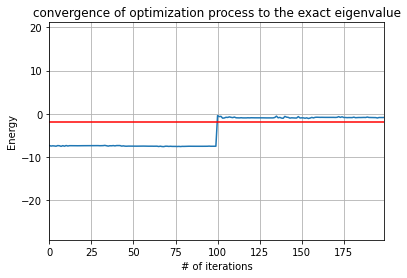

In [35]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

##  Transverse Ising Model 4 qubits

In [36]:
transverse_ising_4_qubits = 0.0 * (I^I^I^I) \
    + 0.8398088405253477 * (X^I^I^I) \
    + 0.7989496312070936 * (I^X^I^I) \
    + 0.38189710487113193 * (Z^Z^I^I) \
    + 0.057753122422666725 * (I^I^X^I) \
    + 0.5633292636970458 * (Z^I^Z^I) \
    + 0.3152740621483513 * (I^Z^Z^I) \
    + 0.07209487981989715 * (I^I^I^X) \
    + 0.17892334004292654 * (Z^I^I^Z) \
    + 0.2273896497668042 * (I^Z^I^Z) \
    + 0.09762902934216211 * (I^I^Z^Z)

In [37]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits)

11it [00:04,  2.32it/s]
11it [00:05,  1.98it/s]
11it [00:05,  1.99it/s]
11it [00:12,  1.10s/it]
11it [00:08,  1.37it/s]
11it [00:07,  1.48it/s]
11it [00:06,  1.78it/s]
11it [00:05,  1.98it/s]
11it [00:04,  2.22it/s]
11it [00:04,  2.25it/s]
11it [00:05,  2.06it/s]
11it [00:05,  1.88it/s]
11it [00:04,  2.33it/s]
11it [00:04,  2.37it/s]
11it [00:04,  2.37it/s]
11it [00:04,  2.59it/s]
11it [00:04,  2.32it/s]
11it [00:05,  2.00it/s]
11it [00:07,  1.55it/s]
11it [00:05,  2.09it/s]
11it [00:04,  2.37it/s]
11it [00:05,  2.13it/s]
11it [00:04,  2.58it/s]
11it [00:04,  2.39it/s]
11it [00:05,  1.94it/s]
11it [00:06,  1.83it/s]
11it [00:06,  1.81it/s]
11it [00:05,  2.01it/s]
11it [00:05,  2.04it/s]
11it [00:04,  2.28it/s]
11it [00:05,  2.03it/s]
11it [00:04,  2.29it/s]
11it [00:05,  2.02it/s]
11it [00:05,  2.13it/s]
11it [00:07,  1.39it/s]
11it [00:07,  1.51it/s]
11it [00:08,  1.37it/s]
11it [00:05,  2.06it/s]
11it [00:05,  1.97it/s]
11it [00:05,  1.86it/s]
11it [00:05,  2.07it/s]
11it [00:05,  1.

11it [00:09,  1.20it/s]
11it [00:09,  1.15it/s]
11it [00:09,  1.11it/s]
11it [00:08,  1.37it/s]
11it [00:08,  1.27it/s]
11it [00:08,  1.35it/s]
11it [00:09,  1.12it/s]
11it [00:09,  1.19it/s]
11it [00:08,  1.27it/s]
11it [00:08,  1.30it/s]
11it [00:07,  1.47it/s]
11it [00:08,  1.26it/s]
11it [00:08,  1.26it/s]
11it [00:08,  1.25it/s]
11it [00:08,  1.25it/s]
11it [00:09,  1.20it/s]
11it [00:08,  1.28it/s]
11it [00:08,  1.26it/s]
11it [00:07,  1.38it/s]
11it [00:07,  1.40it/s]
11it [00:06,  1.79it/s]
11it [00:09,  1.22it/s]
11it [00:08,  1.24it/s]
11it [00:08,  1.30it/s]
11it [00:08,  1.30it/s]
11it [00:10,  1.09it/s]
11it [00:09,  1.17it/s]
11it [00:09,  1.20it/s]
11it [00:10,  1.09it/s]
11it [00:09,  1.18it/s]
11it [00:09,  1.11it/s]
11it [00:08,  1.25it/s]
11it [00:09,  1.19it/s]
11it [00:10,  1.09it/s]
11it [00:08,  1.29it/s]
11it [00:09,  1.13it/s]
11it [00:09,  1.13it/s]
11it [00:10,  1.03it/s]
11it [00:08,  1.23it/s]
11it [00:09,  1.17it/s]
11it [00:09,  1.20it/s]
11it [00:09,  1.

### The optimal parameters found by the optimizer ###
[4.74891096 4.58420965 0.79255622 2.84649475 1.63554931 6.31404129
 4.60037215 4.80126945 3.80268021 1.88694265 2.24109918 2.10100308
 0.64630434 1.39060108 6.29842456 0.20551574 1.36993982 1.11164796
 1.71496507 1.68752746 3.74456861 2.12272718 4.73489073 3.88110767
 5.68815536 2.89243888 2.718398   0.56291139 5.42921451 5.64524638
 5.925536   4.89264835]


11it [00:09,  1.18it/s]

CPU times: total: 21min 37s
Wall time: 45min 33s


[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j), (-0.5462047134056278+0j), (-0.47710503946487287+0j), (-0.31907768442618767+0j), (-0.2505930484227001+0j), (0.14239915569453057+0j), (0.20992649961322052+0j), (0.2757654176709828+0j), (0.3444947223438019+0j), (1.6816520928402046+0j), (1.6958488386667439+0j), (2.3718326043433704+0j), (2.3867070442313216+0j)]
Exact Eigenvalue:
(-1.9994855800333675+0j)

Approximated Eigenvalue:
0.011200644939502166

Approximation Error
0.9943982367008042


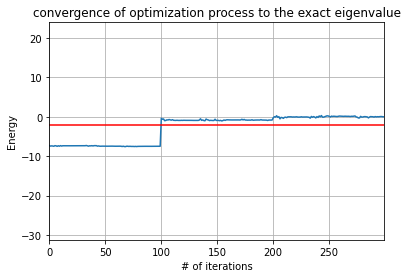

In [38]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

##  Transverse Ising Model 3 qubits

In [39]:
QUBITS_NUM = 3 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 100

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [40]:
from qiskit.opflow import X, Z, I

transverse_ising_3_qubits = 0.0 * (I^I^I) \
                    + 0.012764169333459807 * (X^I^I) \
                    + 0.7691573729160869 * (I^X^I) \
                    + 0.398094746026449 * (Z^Z^I) \
                    + 0.15250261906586637 * (I^I^X) \
                    + 0.2094051920882264 * (Z^I^Z) \
                    + 0.5131291860752999 * (I^Z^Z)

In [41]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits)

QiskitError: 'StatePreparation parameter vector has 8 elements, therefore expects 3 qubits. However, 4 were provided.'

[(-1.1327102067329746+0j), (-1.1089522226243493+0j), (-0.8673630797839832+0j), (-0.8433012058342556+0j), (0.5479228225821259+0j), (0.5543478038595204+0j), (1.4216636087077101+0j), (1.4283924798262082+0j)]
Exact Eigenvalue:
(-1.1327102067329746+0j)

Approximated Eigenvalue:
0.011200644939502166

Approximation Error
0.9901116412009673


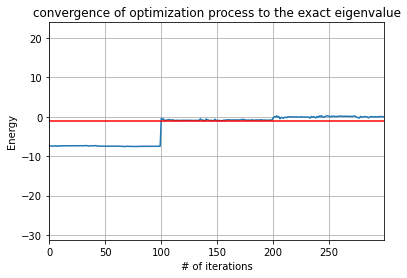

In [42]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

##  Transverse Ising Model 2 qubits

In [43]:
QUBITS_NUM = 2 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 100

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [44]:
transverse_ising_2_qubits = 0.13755727363376802 * (I^X) \
                            + 0.43305656297810435 * (X^I) \
                            + 0.8538597608997253 * (Z^Z)

In [45]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits)

QiskitError: 'StatePreparation parameter vector has 4 elements, therefore expects 2 qubits. However, 4 were provided.'

[(-1.0269745088446245+0j), (-0.9035465241407018+0j), (0.9035465241407012+0j), (1.0269745088446243+0j)]
Exact Eigenvalue:
(-1.0269745088446245+0j)

Approximated Eigenvalue:
0.011200644939502166

Approximation Error
0.9890935511611645


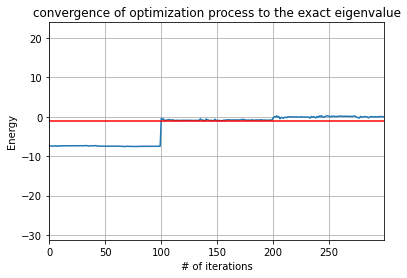

In [46]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

## H2 Molecule 2 qubits

In [47]:
from qiskit.opflow import X, Z, I

H2_molecule_Hamiltonian_2_qubits = -0.5053051899926562*(I^I) + \
                            -0.3277380754984016*(Z^I) + \
                            0.15567463610622564*(Z^Z) + \
                            -0.3277380754984016*(I^Z)

In [48]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits)

QiskitError: 'StatePreparation parameter vector has 4 elements, therefore expects 2 qubits. However, 4 were provided.'

[(-1.0051067048832336+0j), (-0.6609798260988818+0j), (-0.6609798260988818+0j), (0.30584559711037274+0j)]
Exact Eigenvalue:
(-1.0051067048832336+0j)

Approximated Eigenvalue:
-0.8770112173013271

Approximation Error
0.12744466528734152


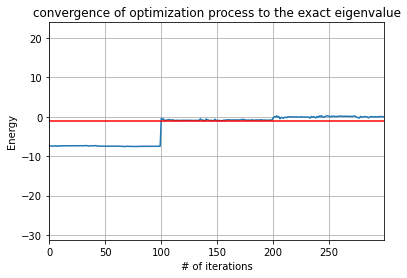

In [49]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)